<a href="https://colab.research.google.com/github/helloconey/TradingPrediction-Project/blob/master/toymodel_7days.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Regression and Classification Based On Indicators:

https://zhuanlan.zhihu.com/p/127981501


- Regression Model: Predict next trading day price

- Classifier Model: Price increasing [1;0] or decreasing [0;1]


In [ ]:
%pylab inline
import pandas as pd
import numpy as np
import datetime
import pandas_datareader.data as web
import pprint
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [ ]:
# install pydrive to load data
#!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id = "1ZkC4hXQ9EfgYAyzMVtAiTMoxct3xwzxL"  
file = drive.CreateFile({'id':id}) 
file.GetContentFile('DOW20181001-1005') 

In [ ]:
import pandas as pd

df = pd.read_csv('DOW20181001-1005')
df.head()

,symbol,timestamp,bid_price,bid_size,bid_price_lag,bid_size_lag,V_of_B,ask_price,ask_size,ask_price_lag,ask_size_lag,V_of_A,VOI,OIR,bid_ask_spread,VWAP_max,VWAP_mean,VWAP_min,size_mean,EWM,RSI,Stochastic,WilliamsR,MACD,Signal_line,OBV
0,AAPL,2018-10-01 13:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,227.500000,221.985481,210.100000,87.500000,224.023750,NaN,NaN,NaN,0.000000,0.000000,1.000000
1,AAPL,2018-10-01 13:30:10+00:00,227.73,100.0,-0.18,0.0,0.0,227.71,100.0,-0.79,0.0,0.0,0.0,0.0,-0.02,222.004333,219.904810,216.443333,61.538462,223.973805,NaN,NaN,NaN,-0.057796,-0.032109,-60.538462
2,AAPL,2018-10-01 13:30:20+00:00,227.78,100.0,0.05,0.0,100.0,227.49,100.0,-0.22,0.0,0.0,100.0,0.0,-0.29,226.593252,225.557095,222.187419,60.000000,227.551120,NaN,NaN,NaN,0.142421,0.039420,61.000000
3,AAPL,2018-10-01 13:30:30+00:00,227.60,100.0,-0.18,0.0,0.0,227.54,0.0,0.05,-100.0,0.0,0.0,1.0,-0.06,226.708649,226.655763,226.598598,46.808511,227.552215,NaN,NaN,NaN,0.279981,0.120911,47.808511
4,AAPL,2018-10-01 13:30:40+00:00,227.60,100.0,0.00,0.0,0.0,227.54,0.0,0.00,0.0,0.0,0.0,1.0,-0.06,226.708649,226.655763,226.598598,46.808511,227.552215,NaN,NaN,NaN,0.350160,0.189107,47.808511


In [ ]:
df.describe([0.05, 0.1, 0.5, 0.9, 0.95])

,bid_price,bid_size,bid_price_lag,bid_size_lag,V_of_B,ask_price,ask_size,ask_price_lag,ask_size_lag,V_of_A,VOI,OIR,bid_ask_spread,VWAP_max,VWAP_mean,VWAP_min,size_mean,EWM,RSI,Stochastic,WilliamsR,MACD,Signal_line,OBV
count,335752.000000,335752.000000,335752.000000,335752.000000,335752.000000,335752.000000,335752.000000,335752.000000,335752.00000,335752.000000,335752.000000,335752.000000,335752.000000,340540.000000,340540.000000,340540.000000,340540.000000,340540.000000,323562.000000,3.264430e+05,3.264430e+05,340540.000000,340540.000000,342926.000000
mean,134.003054,158.022645,-0.000436,-0.042058,36.141825,134.133205,157.381898,0.000015,-0.01544,32.484739,3.657086,-0.009100,0.130150,133.837496,133.835968,133.834012,80.920508,133.756130,43.736958,NaN,NaN,-0.000642,-0.000635,-3.362678
std,79.930639,369.991175,0.189759,387.335871,315.694054,79.902723,343.513747,0.139652,355.59733,271.902899,415.411291,0.560223,1.349377,79.626938,79.626174,79.624954,132.263402,79.644291,48.368019,NaN,NaN,0.092468,0.090487,151.244792
min,40.000000,0.000000,-41.600000,-68059.000000,-68059.000000,43.920000,0.000000,-38.390000,-46329.00000,-46329.000000,-68059.000000,-1.000000,-1.450000,44.036918,44.036915,43.942000,0.000000,42.131790,0.000000,-inf,-inf,-4.597603,-4.232344,-35205.062500
5%,45.930000,0.000000,-0.040000,-200.000000,-100.000000,45.970000,0.000000,-0.040000,-200.00000,-100.000000,-300.000000,-1.000000,-0.040000,46.178599,46.178515,46.178267,0.000000,45.964905,0.000000,0.000000e+00,-1.000000e+02,-0.017309,-0.017377,-113.285714
10%,48.150000,0.000000,-0.020000,-100.000000,0.000000,48.180000,0.000000,-0.020000,-100.00000,0.000000,-100.000000,-1.000000,-0.020000,48.243590,48.243424,48.243343,45.454545,48.173369,0.000000,6.613671e-01,-9.933863e+01,-0.009546,-0.009568,-91.625201
50%,115.460000,100.000000,0.000000,0.000000,0.000000,115.490000,100.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.010000,115.428062,115.424206,115.423721,55.555556,115.439167,0.000000,9.178271e+00,-9.082173e+01,-0.000317,-0.000319,1.000000
90%,264.300000,300.000000,0.020000,100.000000,100.000000,264.520000,300.000000,0.020000,100.00000,100.000000,114.000000,1.000000,0.100000,264.657588,264.656444,264.655873,121.000000,264.099764,100.000000,9.922299e+01,-7.770073e-01,0.007126,0.007176,89.609353
95%,269.670000,400.000000,0.040000,200.000000,300.000000,269.760000,400.000000,0.040000,200.00000,300.000000,300.000000,1.000000,0.170000,269.553041,269.552495,269.552188,196.000000,269.675795,100.000000,1.000000e+02,-0.000000e+00,0.015903,0.015956,121.000000
max,394.190000,73473.000000,41.610000,72909.000000,39158.000000,394.300000,47579.000000,39.570000,41285.00000,41285.000000,46329.000000,1.000000,47.800000,391.953499,391.953497,391.953494,35206.062500,394.233459,100.000000,inf,inf,4.950093,4.686018,10101.000000


In [ ]:
df.shape

(342926, 26)

### Data Cleaning

In [ ]:
df = df.replace([np.inf, -np.inf], np.nan)

In [ ]:
df = df.dropna()

In [ ]:
new_df = df.loc[:, ["symbol", "timestamp", "MACD","RSI","OBV","Stochastic","WilliamsR","EWM", "Signal_line", "VOI", "OIR", "bid_ask_spread", "VWAP_mean"]]

### Visualization: MACD

https://www.kaggle.com/kratisaxena/stock-market-technical-indicators-visualization

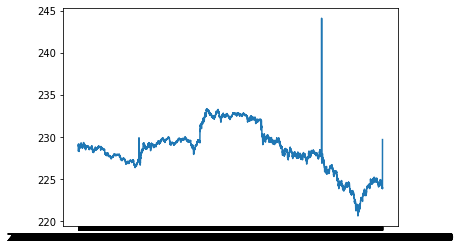

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl

aapl = df[df['symbol'] == 'AAPL']

plt.plot(aapl['timestamp'], aapl['ask_price'])
plt.show()

### VWAP

np.cumsum(data['Size'] * (data['High'] + data['Low'])/2) / np.cumsum(data['Size'])


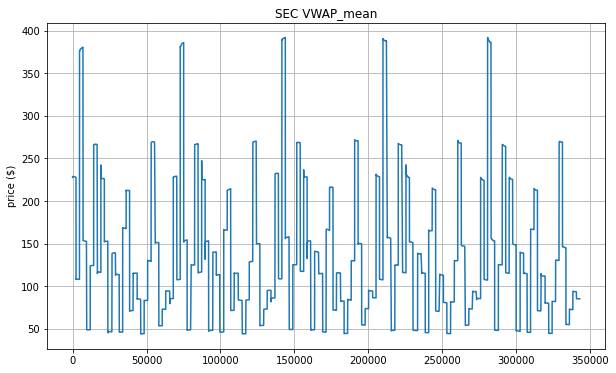

In [ ]:
#Plot VWAP_mean

new_df['VWAP_mean'].plot(grid=True, figsize=(10,6))
plt.title('SEC VWAP_mean')
plt.ylabel('price ($)')
plt.show()

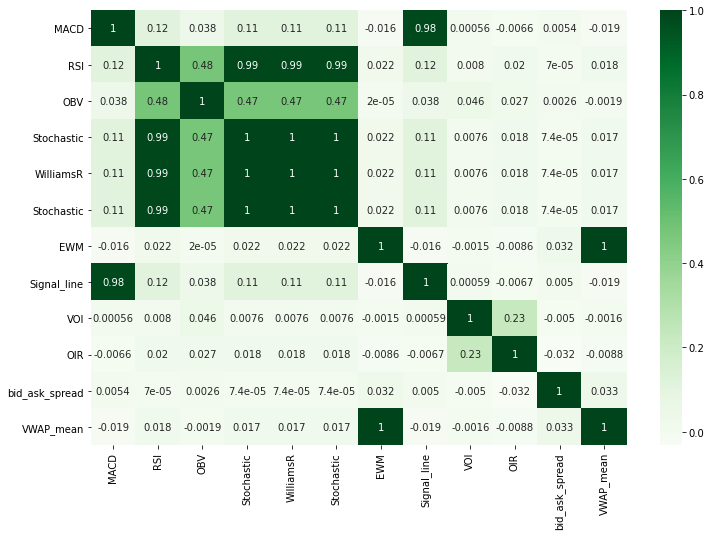

In [ ]:
# Check correlation
import seaborn as sns
f,ax = plt.subplots(figsize=(12,8))
sns.heatmap(new_df.corr(),ax=ax,annot=True,cmap='Greens');

### Data Preprocessing

In [ ]:
new_df.reset_index(inplace=True)

In [ ]:
new_df.drop(columns="index", axis=1)

,symbol,timestamp,MACD,RSI,OBV,Stochastic,WilliamsR,Stochastic,EWM,Signal_line,VOI,OIR,bid_ask_spread,VWAP_mean
0,AAPL,2018-10-01 13:32:20+00:00,0.520153,79.063903,50.382716,99.714504,-0.285496,99.714504,228.422493,0.463558,0.0,0.000000,-0.13,227.762338
1,AAPL,2018-10-01 13:32:30+00:00,0.526312,100.000000,51.000000,99.657458,-0.342542,99.657458,228.473302,0.476473,0.0,0.000000,-0.14,227.817266
2,AAPL,2018-10-01 13:32:40+00:00,0.527984,100.000000,51.000000,99.089805,-0.910195,99.089805,228.438155,0.487012,0.0,0.000000,-0.10,227.848328
3,AAPL,2018-10-01 13:32:50+00:00,0.525762,100.000000,51.000000,99.078647,-0.921353,99.078647,228.464166,0.494904,-100.0,0.000000,-0.02,227.872291
4,AAPL,2018-10-01 13:33:00+00:00,0.521598,100.000000,52.006711,97.859135,-2.140865,97.859135,228.553426,0.500321,0.0,0.000000,-0.19,227.908622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323040,XOM,2018-10-05 19:59:30+00:00,-0.000128,45.849056,80.500000,73.118042,-26.881958,73.118042,85.250750,-0.000154,100.0,0.333333,-0.02,85.219866
323041,XOM,2018-10-05 19:59:40+00:00,-0.000109,61.536723,138.642857,72.918572,-27.081428,72.918572,85.284840,-0.000145,634.0,0.760192,-0.02,85.219953
323042,XOM,2018-10-05 19:59:50+00:00,-0.000086,69.569114,51.000000,96.957333,-3.042667,96.957333,85.311423,-0.000133,0.0,0.000000,-0.02,85.220031
323043,XOM,2018-10-05 20:00:00+00:00,-0.000065,70.050956,1.000000,100.000000,-0.000000,100.000000,85.581774,-0.000120,0.0,1.000000,3.87,85.220040


Use apple stock for practice: 

In [ ]:
aapl = df[df['symbol'] == 'AAPL'].loc[:, ["MACD","RSI","OBV","WilliamsR","Stochastic","EWM", "Signal_line", "VOI", "OIR", "bid_ask_spread", "VWAP_mean"]]

In [ ]:
#Class for y:

aapl['pred_price'] = np.where(aapl['VWAP_mean'].shift(-1) > aapl['VWAP_mean'], 1, 0)

In [ ]:
aapl['pred_price'].unique()

array([1, 0])

In [ ]:
#Normalize the dataframe:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer


y = aapl["pred_price"]
X = aapl.drop(columns=["VWAP_mean", "pred_price"], axis=1)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)


In [ ]:
normalizer = Normalizer()

#Normalize train data
normalized_train_X = normalizer.fit_transform(X_train)

#Normalize test data
normalized_test_X = normalizer.transform(X_test)

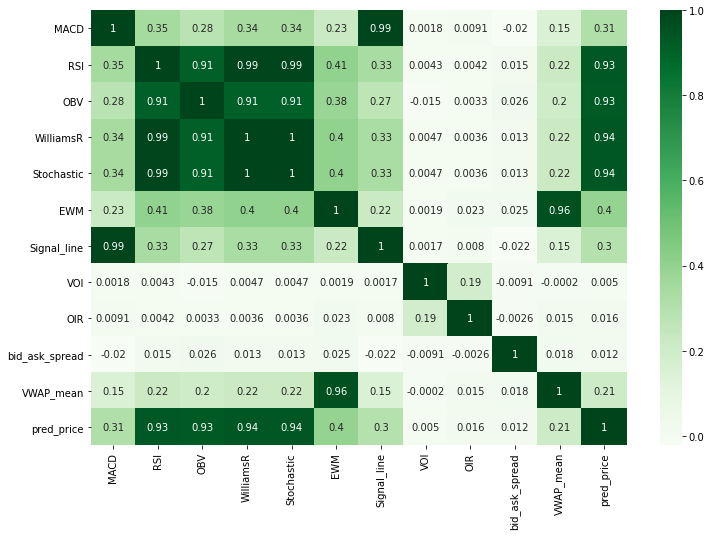

In [ ]:
f,ax = plt.subplots(figsize=(12,8))
sns.heatmap(aapl.corr(),ax=ax,annot=True,cmap='Greens');

## Time for Classifications

In [ ]:
import time
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier



dict_clf = { 'log': LogisticRegression(),
             'rf': RandomForestClassifier()
}

In [ ]:
no_clf = len(dict_clf.keys())

def batch_clf(normalized_train_X, y_train, verbose=True):
  df_results = pd.DataFrame(data=np.zeros(shape=(no_clf,3)), columns=['classifier', 'train_score', 'train_time'])

  count = 0

  for key, clfs in dict_clf.items():
    t_start = time.process_time()
    clfs.fit(normalized_train_X, y_train, y_train)
    t_end = time.process_time()
    t_diff = t_end - t_start
    train_score = clfs.score(normalized_train_X, y_train)
    df_results.loc[count, 'classifier'] = key
    df_results.loc[count, 'train_score'] = train_score
    df_results.loc[count, 'train_time'] = t_diff

    if verbose:
      print("trained {c} in {f: .2f} s".format(c=key, f=t_diff))
    count+=1
  return df_results

In [ ]:
df_results = batch_clf(normalized_train_X, y_train)
print(df_results.sort_values(by='train_score', ascending=True))

trained log in  0.10 s
trained rf in  0.35 s
  classifier  train_score  train_time
0        log     0.380707    0.102049
1         rf     0.380707    0.346942


## Time for Regression

In [ ]:
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

y1 = aapl["VWAP_mean"]


X_train_, X_test_, y_train_, y_test_ = train_test_split(
    X, y1, test_size=0.3, random_state=42)

dict_rg = {  'svr': SVR(),
             'rf': RandomForestRegressor()
}

In [ ]:
#Normalize train data
normalized_train_X_ = normalizer.fit_transform(X_train_)

#Normalize test data
normalized_test_X_ = normalizer.transform(X_test_)

In [ ]:
no_rg = len(dict_rg.keys())


def batch_rg(normalized_train_X_, y_train_, verbose=True):
  df_results = pd.DataFrame(data=np.zeros(shape=(no_rg,3)), columns=['regression', 'train_score', 'train_time'])

  count = 0

  for key, rgs in dict_rg.items():
    t_start = time.process_time()
    rgs.fit(normalized_train_X_, y_train_)
    t_end = time.process_time()
    t_diff = t_end - t_start
    train_score = rgs.score(normalized_train_X_, y_train_)
    df_results.loc[count, 'regression'] = key
    df_results.loc[count, 'train_score'] = train_score
    df_results.loc[count, 'train_time'] = t_diff

    if verbose:
      print("trained {c} in {f: .2f} s".format(c=key, f=t_diff))
    count+=1
  return df_results

In [ ]:
df_results_ = batch_rg(normalized_train_X_, y_train_)
print(df_results_.sort_values(by='train_score', ascending=True))

trained svr in  4.62 s
trained rf in  6.98 s
  regression  train_score  train_time
0        svr     0.085640    4.617204
1         rf     0.974764    6.981698


without normalize:

In [ ]:
dict_rg2 = { 'lasso': linear_model.Lasso(),
             'elastic': ElasticNet()
}

In [ ]:
no_rg2 = len(dict_rg2.keys())


def batch_rg(train_X_, y_train_, verbose=True):
  df_results = pd.DataFrame(data=np.zeros(shape=(no_rg2,3)), columns=['regression', 'train_score', 'train_time'])

  count = 0

  for key, rgs in dict_rg2.items():
    t_start = time.process_time()
    rgs.fit(train_X_, y_train_)
    t_end = time.process_time()
    t_diff = t_end - t_start
    train_score = rgs.score(train_X_, y_train_)
    df_results.loc[count, 'regression'] = key
    df_results.loc[count, 'train_score'] = train_score
    df_results.loc[count, 'train_time'] = t_diff

    if verbose:
      print("trained {c} in {f: .2f} s".format(c=key, f=t_diff))
    count+=1
  return df_results

In [ ]:
rfr = RandomForestRegressor()
rfr.fit(X_train_, y_train_)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
[*zip(rfr.feature_importances_, X_train_.columns)]

[(0.014856271727620692, 'MACD'),
 (0.004344292481522518, 'RSI'),
 (0.0036702851071803684, 'OBV'),
 (0.000493498195847309, 'WilliamsR'),
 (0.0005015601356277623, 'Stochastic'),
 (0.9694950837423355, 'EWM'),
 (0.005555052405137719, 'Signal_line'),
 (6.469769785082027e-05, 'VOI'),
 (5.121691371538936e-05, 'OIR'),
 (0.0009680415931620809, 'bid_ask_spread')]

In [ ]:
df_results__ = batch_rg(X_train_, y_train_)
print(df_results__.sort_values(by='train_score', ascending=True))

trained lasso in  0.01 s
trained elastic in  0.01 s
  regression  train_score  train_time
0      lasso     0.927092    0.009837
1    elastic     0.935513    0.009737


In [ ]:
X_train_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8148 entries, 276476 to 205453
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MACD            8148 non-null   float64
 1   RSI             8148 non-null   float64
 2   OBV             8148 non-null   float64
 3   WilliamsR       8148 non-null   float64
 4   Stochastic      8148 non-null   float64
 5   EWM             8148 non-null   float64
 6   Signal_line     8148 non-null   float64
 7   VOI             8148 non-null   float64
 8   OIR             8148 non-null   float64
 9   bid_ask_spread  8148 non-null   float64
dtypes: float64(10)
memory usage: 700.2 KB


1. convert vwap_mean to returns (using pct_change() )
2. we need to take our feature set (X vars), and shift() that data by 1 lag to start
3. get the info()
4. Get off VOI because it combine with V_of_A and V_of_B
5. convert to % change
6. pattern change between morning and afternoon, better predict previous day for next day
7. prediction > 0, signal 1; negative, signal -1
8. multiply 10 second returns for that day by signal
9. strategy_ret = ret * signal
10. Don't use rmse, but use other metric to evaluate

## Correlation with different tickers:

In [ ]:
CSCO = df[df['symbol'] == 'CSCO'].loc[:, ["MACD","RSI","OBV","WilliamsR","Stochastic","EWM", "Signal_line", "VOI", "OIR", "bid_ask_spread", "VWAP_mean"]]

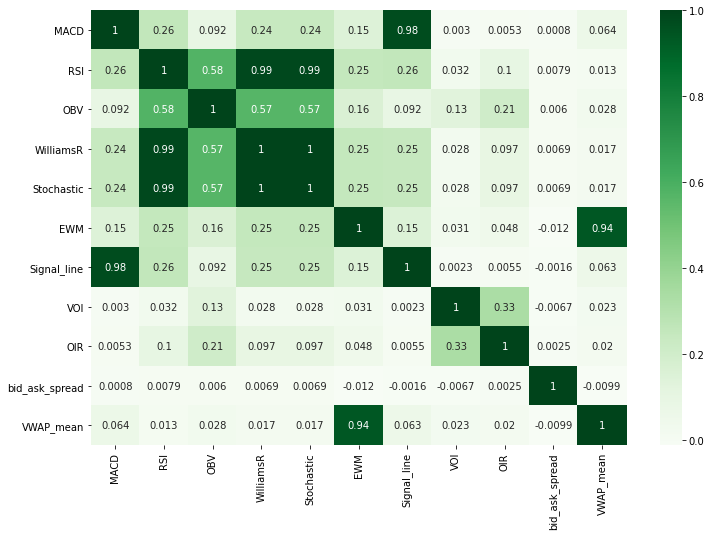

In [ ]:
f,ax = plt.subplots(figsize=(12,8))
sns.heatmap(CSCO.corr(),ax=ax,annot=True,cmap='Greens');